In [2]:
from modules import *
%matplotlib widget
# %matplotlib inline
# %matplotlib notebook

### 1. Load dataset

FileChooser(path='C:\git\JoaoAmaro2001\notebooks\src\ingestion', filename='', title='<b>Select the Dataset fol…

Loading dataset: Lisbon_Belem_sub-OE101031_2024-05-15T104442Z...
@(WIN) --> I:\João\Exp_4-outdoor_experiment\OE031\Lisbon_Belem_sub-OE101031_2024-05-15T104442Z\20240515124436_OE101031_EXP4.nedf
Reading file...
Header information has been correctly retrieved.
Attempting to automatically correct eeg timestamps to harp timestamps...
Done.
Dataset: <pluma.schema.Dataset object at 0x000001B1512F4B90> loaded successfully, and sucessfully calibrated.


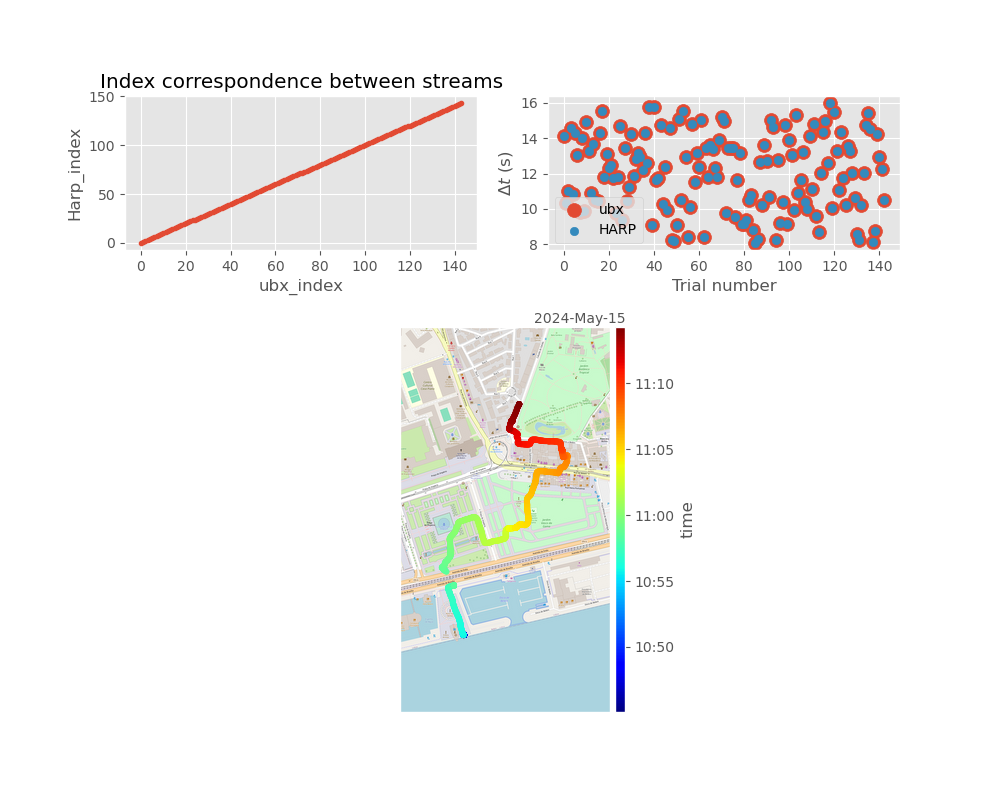

Failed Stream Harp stream from device 		TK, stream GPS_Latitude(227): Input dataframe is empty.
Failed Stream Harp stream from device 		TK, stream GPS_Longitude(228): Input dataframe is empty.
Failed Stream Harp stream from device 		TK, stream GPS_Altitude(229): Input dataframe is empty.
Failed Stream Harp stream from device 		TK, stream GPS_HasFix(232): Input dataframe is empty.


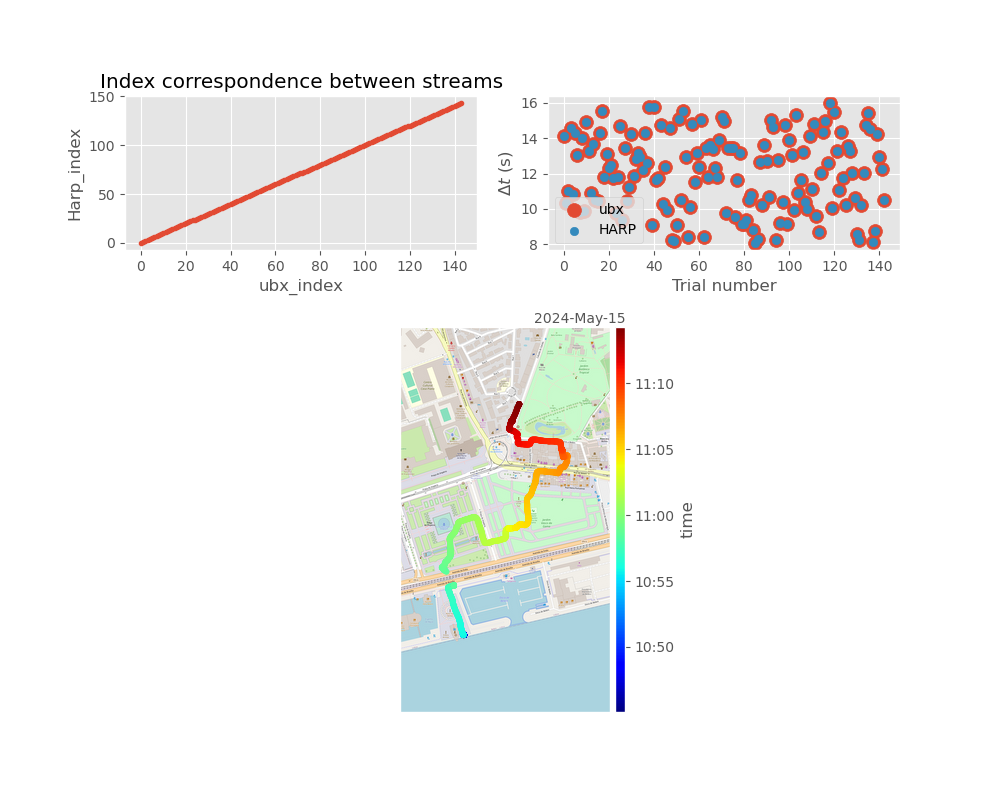

In [ ]:
datapicker = create_datapicker()
display(datapicker) # type -> ipyfilechooser.filechooser.FileChooser

### 2. Explore Dataset Maps

In [ ]:
# datapicker.geodata
"""Assess datapicker geodata information

"""
import pprint

# pprint.pprint(dir(datapicker.geodata))
pprint.pprint(datapicker.geodata.columns)
methods = [method for method in dir(datapicker.geodata) if not method.startswith('__') and not method.endswith('__')]
pprint.pprint(methods)

In [49]:
"""
Use this cell to obtain other types of information from the datapicker object.
For example, the following code will display the type of the geodata attribute.
Use it to export some information.
"""

print(type(datapicker.geodata)) # <class 'geopandas.geodataframe.GeoDataFrame'>
datapicker.geodata.to_csv(r'C:\git\JoaoAmaro2001\notebooks\src\output\geodata.csv') # Save the data to a csv file
datapicker.geodata.to_file(r'C:\git\JoaoAmaro2001\notebooks\src\output\geodata.geojson', driver='GeoJSON') # Save the data to a geojson file

<class 'geopandas.geodataframe.GeoDataFrame'>


c:\git\JoaoAmaro2001\notebooks\.conda\Lib\site-packages\pandas\core\frame.py:706: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
c:\git\JoaoAmaro2001\notebooks\.conda\Lib\site-packages\geopandas\geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
c:\git\JoaoAmaro2001\notebooks\.conda\Lib\site-packages\geopandas\geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
c:\git\JoaoAmaro2001\notebooks\.conda\Lib\site-packages\pandas\core\frame.py:706: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
c:\git\JoaoAmaro2001

#### 2.1. Create new variables

In [13]:
"""Compute UTCI across whole time series
- pip install pythermalcomfort
- See docs (https://pypi.org/project/pythermalcomfort/)
UTCI:
The parameters that are taken into account for calculating UTCI involve dry bulb temperature, mean radiation temperature, the pressure of water vapor or relative humidity, and wind speed (at the elevation of 10 m above the ground).
"""
import pandas as pd
from pythermalcomfort.models import utci

# Define custom parameters
humidity = datapicker.geodata.tk_humidity_humidity_value / 100 # in % or fraction?
wind_speed = np.sqrt(datapicker.geodata.atmos_northwind_value**2 + datapicker.geodata.atmos_eastwind_value**2) # m/s (~2.5 m of elevation)
temp_atmos= datapicker.geodata.atmos_airtemperature_value # in ºC
temp_tk = datapicker.geodata.tk_airquality_temperature_value/100 # in ºC)
temp_tk_ptc = datapicker.geodata.tk_ptc_airtemp_value/100 # positive temperature coefficient (in ºC
temp_radiant = datapicker.geodata.tk_thermocouple_temperature_value/100 # in ºC

# Assign custom parameters to the geodata attribute
datapicker.geodata['humidity'] = humidity
datapicker.geodata['wind_speed'] = wind_speed
datapicker.geodata['temp_atmos'] = temp_atmos
datapicker.geodata['temp_tk'] = temp_tk
datapicker.geodata['temp_tk_ptc'] = temp_tk_ptc
datapicker.geodata['temp_radiant'] = temp_radiant

# Compute the UTCI
utci = utci(tdb=temp_atmos, tr=temp_radiant, v=wind_speed, rh=humidity)
datapicker.geodata['utci'] = utci

c:\git\JoaoAmaro2001\notebooks\.conda\Lib\site-packages\geopandas\geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
c:\git\JoaoAmaro2001\notebooks\.conda\Lib\site-packages\geopandas\geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
c:\git\JoaoAmaro2001\notebooks\.conda\Lib\site-packages\geopandas\geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
c:\git\JoaoAmaro2001\notebooks\.conda\Lib\site-packages\geopandas\geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs =

#### 2.2. Get geojson file for maps

In [ ]:
import geopandas as gpd

# Define the file path of the GeoJSON file
filepath = r"G:\Shared drives\Shared_FMUL_eMC\WP5\4_OutdoorExperiment\LisbonWalks\Useful Documents\exp4percursos\geojson_files\belem_geosjon.geojson"

# Read the GeoJSON file into a GeoDataFrame
gdf = gpd.read_file(filepath)

# Print the GeoDataFrame
print(gdf)

In [48]:
# Check ideal path (customize for path)

import folium
import numpy as np

# Calculate the mean latitude and longitude
mean_lat = np.mean(gdf.geometry[0].coords.xy[1])
mean_lon = np.mean(gdf.geometry[0].coords.xy[0])

# Create a map centered at the mean of the coordinates in the LineString
m = folium.Map(location=[mean_lat, mean_lon], zoom_start=13)

# Add the LineString to the map
folium.GeoJson(gdf.geometry[0]).add_to(m)

# Show the map
m

#### 2.3. Visualize maps

In [47]:
"""exploremap kwargs
- see (here)[https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.explore.html]
"""

map = exploremap(datapicker.geodata, column='utci', cmap = 'hot')
folium.GeoJson(gdf.geometry[0]).add_to(map)
map # Display the map

c:\git\JoaoAmaro2001\notebooks\.conda\Lib\site-packages\pandas\core\frame.py:706: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
c:\git\JoaoAmaro2001\notebooks\.conda\Lib\site-packages\geopandas\geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
c:\git\JoaoAmaro2001\notebooks\.conda\Lib\site-packages\geopandas\geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
c:\git\JoaoAmaro2001\notebooks\.conda\Lib\site-packages\pandas\core\frame.py:706: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
c:\git\JoaoAmaro2001

In [1]:
dir(gdf.geometry[0].xy)
# gdf.geometry[0].xy

NameError: name 'gdf' is not defined

### 3. Explore Dataset Streams (without EEG)

c:\git\JoaoAmaro2001\notebooks\.conda\Lib\site-packages\ipywidgets\widgets\widget.py:503: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)


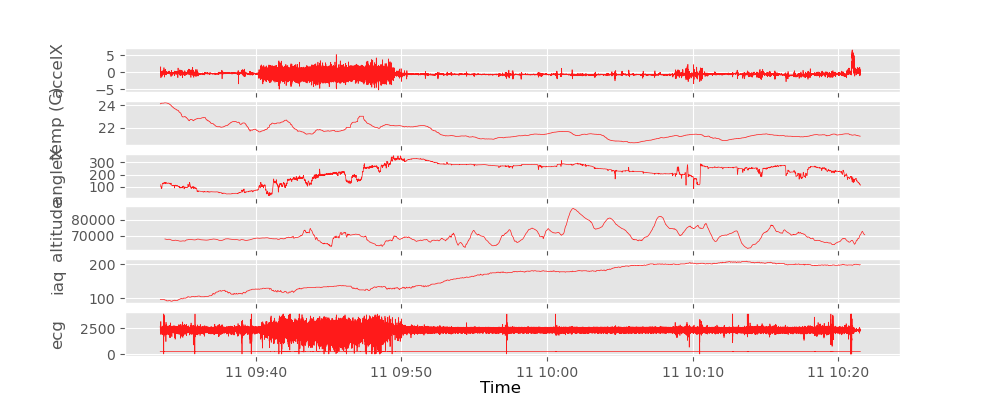

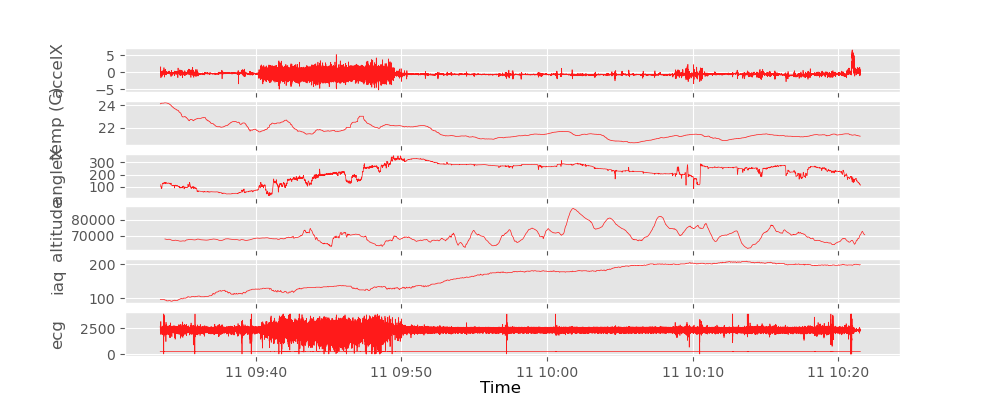

In [18]:
plot_traces({
    'accelX': datapicker.dataset.streams.Accelerometer.data["Accl_X"],
    'temp (C)': datapicker.dataset.streams.TK.AirQuality.Temperature.data/100,
    'angleX': datapicker.dataset.streams.Accelerometer.data["Orientation_X"],
    'altitude': datapicker.dataset.georeference.elevation,
    'iaq': datapicker.dataset.streams.TK.AirQuality.IAQIndex.data,
    'ecg': datapicker.dataset.streams.BioData.ECG.data,
    }, 
    segments=[
    ('2024-05-02 13:20:40.731324594', [0.1, 0.1, 0.1]), 
    ('2024-05-02 13:21:10.246332594', [1, 0.1, 0.1])
    ])

### 4. Export Data to CSV

In [ ]:
coords = datapicker.geodata.geometry.get_coordinates(include_z=True)
# coords.rename(columns = {'y':'latitude', 'x':'longitude','z':'elevation'}, inplace = True)
# coords
coords

In [30]:
dataexport = datapicker.geodata.join(coords).drop(columns=['geometry'])
dataexport.to_csv("full_geodata.csv")



### 5. EEG

In [59]:
eeg = datapicker.dataset.streams.EEG
""" Additional information about the dataset
"""
print(dir(datapicker.dataset.streams.EEG))
print(dir(datapicker.dataset.streams.EEG.data.np_markers)) # See attributes of the data
print(datapicker.dataset.streams.EEG_dir__) # See type of data


['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_rootfolder', 'add_clock_offset', 'align_to_harp', 'autoalign', 'autoload', 'clockreference', 'convert_to_si', 'data', 'device', 'export_to_csv', 'load', 'parent_dataset', 'plot', 'reload', 'resample', 'rootfolder', 'server_lsl_marker', 'slice', 'streamlabel', 'streamtype']
['T', '__abs__', '__add__', '__and__', '__array__', '__array_finalize__', '__array_function__', '__array_interface__', '__array_prepare__', '__array_priority__', '__array_struct__', '__array_ufunc__', '__array_wrap__', '__bool__', '__class__', '__class_getitem__', '__complex__', '__contains__', '__copy__', '__deepcopy__', '__delattr__', '__delitem__', '__dir__'

In [48]:
print(eeg.data.np_eeg.shape) # Get the shape (dims) of the EEG data
print(eeg.data._NedfReader__get_info()) # Get the information of the EEG data

(799977, 32)
{"NEDFversion": "1.4", "StepDetails": {"StepName": "EXP4", "StartDate_firstEEGTimestamp": "1715592245520", "DeviceClass": "ENOBIO", "DeviceID": "COM10", "SoftwareVersion": "NIC v2.0.11.7", "FirmwareVersion": "3031", "CommunicationType": "USB", "OperativeSystem": null, "SDCardFilename": "NONE", "NOISEFilter": "NONE", "AdditionalChannel": "NONE", "EOGCorrectionStatus": "NONE"}, "EEGSettings": {"TotalNumberOfChannels": "32", "NumberOfEEGChannels": "32", "NumberOfRecordsOfEEG": "799977", "EEGSamplingRate": "500", "EEGRecordingDuration": "5400", "NumberOfPacketsLost": "0", "LineFilterStatus": "50 Hz", "FIRFilterStatus": "OFF", "EOGFilterStatus": "OFF", "ReferenceFilterStatus": "OFF", "EEGUnits": "nV", "EEGMontage": {"Channel1": "P7", "Channel2": "P4", "Channel3": "Cz", "Channel4": "Pz", "Channel5": "P3", "Channel6": "P8", "Channel7": "O1", "Channel8": "O2", "Channel9": "T8", "Channel10": "F8", "Channel11": "C4", "Channel12": "F4", "Channel13": "Fp2", "Channel14": "Fz", "Channel

#### 5.1. Events

In [46]:
revts = datapicker.dataset.streams.EEG.server_lsl_marker
evts = revts[revts.MarkerIdx>35000]
print(evts)# Type -> <class 'pandas.core.frame.DataFrame'>
if len(evts[evts.MarkerIdx<35099])>4: # Check if acquisition has baseline
    baseline=True
else:
    baseline=False
print(baseline)



                          Seconds  LslTimestamp  MarkerIdx  EegSample  \
1   2024-05-02 13:20:40.731324594   5971.719913      35001      14622   
5   2024-05-02 13:21:10.246332594   6001.234491      35101      29378   
11  2024-05-02 13:22:17.439324594   6068.427420      35201      62973   
14  2024-05-02 13:22:37.130332594   6088.118653      35301      72819   
22  2024-05-02 13:24:01.800348594   6172.788325      35102     115152   
28  2024-05-02 13:24:56.524348594   6227.513153      35202     142513   
31  2024-05-02 13:25:20.682332594   6251.671264      35302     154592   
92  2024-05-02 13:37:22.877340594   6973.867049      35103     515675   
99  2024-05-02 13:38:22.714332594   7033.704483      35203     545592   
102 2024-05-02 13:38:46.440348594   7057.430576      35303     557455   
107 2024-05-02 13:39:35.045340594   7106.035582      35002     581756   

     EegTimestamp  
1       29.243999  
5       58.756001  
11     125.945999  
14     145.638000  
22     230.304001  
28 

In [47]:
revts = datapicker.dataset.streams.EEG.server_lsl_marker
evts = revts[revts.MarkerIdx>35000]
if baseline:
    # Automatically pass checkpoints to the plot_traces function
    beg_bs_close = evts[evts.MarkerIdx==35001].index[0]
    end_bs_close = evts[evts.MarkerIdx==35002].index[0]
    beg_bs_open = evts[evts.MarkerIdx==35003].index[0]
    end_bs_open = evts[evts.MarkerIdx==35004].index[0]
    beg = evts[evts.MarkerIdx==35005].index[0]
    end = evts[evts.MarkerIdx==35006].index[0]
    beg_bs_close_seconds = evts.loc[beg_bs_close, 'Seconds']
    end_bs_close_seconds = evts.loc[end_bs_close, 'Seconds']
    beg_bs_open_seconds = evts.loc[beg_bs_open, 'Seconds']
    end_bs_open_seconds = evts.loc[end_bs_open, 'Seconds']
    beg_seconds = evts.loc[beg, 'Seconds']
    end_seconds = evts.loc[end, 'Seconds']

    evts = evts[evts.MarkerIdx>35099] # Remove the markers ids < 35099
    indexes = evts[(evts.MarkerIdx //100) % 10 == 1].index # Get the indexes of the markers
    sub_dfs = [evts.loc[indexes[i]:indexes[i+1]-1] for i in range(len(indexes)-1)] # Divide the DataFrame by the indexes
    sub_dfs.append(evts.loc[indexes[-1]:])  # Add the last segment from the last index to the end of the DataFrame

    chk_segments = []
    list_dict = {1: [1, 0.1, 0.1], 2: [0.1, 1, 0.1], 3: [0.1, 0.1, 0.1]} # Red, Green, Black

    for df in sub_dfs:
        for i in range(1, 4):
            index = df[(df.MarkerIdx // 100) % 10 == i].first_valid_index()
            if index is not None:
                chk_segments.append((df.loc[index, 'Seconds'], list_dict[i]))

    # Prepend beg and append end to chk_segments
    chk_segments.insert(0, (beg_bs_close_seconds, [128/255, 0, 128/255])) # Purple color to eyes closed baseline
    chk_segments.insert(1, (end_bs_close_seconds, [1, 1, 1])) # White color to end
    chk_segments.insert(2, (beg_bs_open_seconds, [0.1, 0.1, 1])) # Blue color to eyes open baseline
    chk_segments.insert(3, (end_bs_open_seconds, [1, 1, 1])) # White color to end
    chk_segments.insert(4, (beg_seconds, [0.1, 0.1, 0.1])) # Black color to beginning
    chk_segments.append((end_seconds, [0.1, 0.1, 0.1])) # Black color to end
    
else:
    first = evts.loc[evts.index[0], 'Seconds']
    beg = evts[evts.MarkerIdx==35001].index[0]
    end = evts[evts.MarkerIdx==35002].index[0] # Will not work when double-clicked
    beg_seconds = evts.loc[beg, 'Seconds']
    end_seconds = evts.loc[end, 'Seconds']

    evts = evts[evts.MarkerIdx>35099] # Remove the markers ids < 35099
    indexes = evts[(evts.MarkerIdx //100) % 10 == 1].index # Get the indexes of the markers
    sub_dfs = [evts.loc[indexes[i]:indexes[i+1]-1] for i in range(len(indexes)-1)] # Divide the DataFrame by the indexes
    sub_dfs.append(evts.loc[indexes[-1]:])  # Add the last segment from the last index to the end of the DataFrame

    chk_segments = []
    list_dict = {1: [1, 0.1, 0.1], 2: [0.1, 1, 0.1], 3: [0.1, 0.1, 0.1]} # Red, Green, Black

    for df in sub_dfs:
        for i in range(1, 4):
            index = df[(df.MarkerIdx // 100) % 10 == i].first_valid_index()
            if index is not None:
                chk_segments.append((df.loc[index, 'Seconds'], list_dict[i]))

    chk_segments.insert(0, (first, [1, 1, 1])) # Black color to beginning
    chk_segments.insert(1, (beg_seconds, [0.1, 0.1, 0.1])) # Black color to beginning
    chk_segments.append((end_seconds, [1, 1, 1])) # Black color to end

print(chk_segments)

[(Timestamp('2024-05-02 13:20:40.731324594'), [1, 1, 1]), (Timestamp('2024-05-02 13:20:40.731324594'), [0.1, 0.1, 0.1]), (Timestamp('2024-05-02 13:21:10.246332594'), [1, 0.1, 0.1]), (Timestamp('2024-05-02 13:22:17.439324594'), [0.1, 1, 0.1]), (Timestamp('2024-05-02 13:22:37.130332594'), [0.1, 0.1, 0.1]), (Timestamp('2024-05-02 13:24:01.800348594'), [1, 0.1, 0.1]), (Timestamp('2024-05-02 13:24:56.524348594'), [0.1, 1, 0.1]), (Timestamp('2024-05-02 13:25:20.682332594'), [0.1, 0.1, 0.1]), (Timestamp('2024-05-02 13:37:22.877340594'), [1, 0.1, 0.1]), (Timestamp('2024-05-02 13:38:22.714332594'), [0.1, 1, 0.1]), (Timestamp('2024-05-02 13:38:46.440348594'), [0.1, 0.1, 0.1]), (Timestamp('2024-05-02 13:39:35.045340594'), [1, 1, 1])]


#### 5.2. Plot

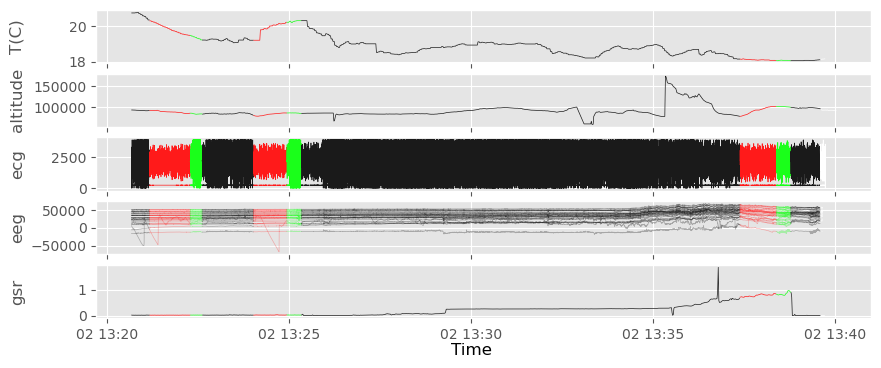

In [48]:
plot_traces({
    'T(C)': datapicker.dataset.streams.TK.AirQuality.Temperature.data/100,
    'altitude': datapicker.dataset.georeference.elevation,
    'ecg': datapicker.dataset.streams.BioData.ECG.data,
    'eeg': datapicker.dataset.streams.EEG.data,
    'gsr': datapicker.geodata.empatica_e4_gsr,
    }, 
    segments = chk_segments
    # figsize = (16,8)
    )

In [ ]:
# Plot the data
eeg.data.np_eeg[14622, 1]
plt.plot(eeg.data.np_eeg)  # np_eeg is a numpy array with the EEG data - for processing purposes
plt.xlim(evts['EegSample'].iloc[0], evts['EegSample'].iloc[-1])  # Set x-axis limits (beginning and end of the event)
plt.show()

#### 5.3. Export EEG to EEGLAB (.set)

In [ ]:
"""Required packages
pip install eeglabio
pip install mne
"""
import mne
from eeglabio.utils import export_mne_raw
raw = mne.io.read_raw(...)
export_mne_raw(raw, "file_name.set")

In [55]:
%whos
help(mne.io.read_raw_nedf) # important to use this function?
import inspect
print(inspect.getsource(mne.io.read_raw_nedf))

Variable                          Type                Data/Info
---------------------------------------------------------------
Contact                           type                <class 'pluma.export.ogcapi.records.Contact'>
DataFrame                         type                <class 'pandas.core.frame.DataFrame'>
Dataset                           type                <class 'pluma.schema.Dataset'>
DatasetRecord                     type                <class 'pluma.export.ogca<...>i.records.DatasetRecord'>
FileChooser                       MetaHasTraits       <class 'ipyfilechooser.filechooser.FileChooser'>
Georeference                      type                <class 'pluma.stream.georeference.Georeference'>
GridSpec                          type                <class 'matplotlib.gridspec.GridSpec'>
HarpStream                        type                <class 'pluma.stream.harp.HarpStream'>
MaxNLocator                       type                <class 'matplotlib.ticker.MaxNLocator'>

In [63]:
import os

import glob
datafolder = datapicker._pathlist.value
nedf_files = glob.glob(os.path.join(datafolder, '*.nedf'))
if nedf_files:
    filename = nedf_files[0]
else:
    print("No .nedf files found in the directory.")
print(filename)
eeg_nedf = mne.io.read_raw_nedf(filename, preload=False, verbose=None)
print(type(eeg_nedf))

I:\João\Exp_4-outdoor_experiment\OE028\Lisbon_Baixa_sub-OE104028_2024-05-13T092413Z\20240513102405_OE104028_EXP4.nedf
<class 'mne.io.nedf.nedf.RawNedf'>


In [62]:
print(type(eeg_nedf))
print(dir(eeg_nedf))

<class 'mne.io.nedf.nedf.RawNedf'>
['__class__', '__contains__', '__del__', '__delattr__', '__dict__', '__dir__', '__doc__', '__enter__', '__eq__', '__exit__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setitem__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_annotations', '_cals', '_check_bad_segment', '_comp', '_cropped_samp', '_dtype', '_dtype_', '_extra_attributes', '_filenames', '_first_samps', '_first_time', '_get_buffer_size', '_get_channel_positions', '_getitem', '_handle_tmin_tmax', '_init_kwargs', '_last_samps', '_last_time', '_orig_units', '_parse_get_set_params', '_pick_drop_channels', '_pick_projs', '_preload_data', '_projector', '_projectors', '_raw_extras', '_raw_lengths', '_read_comp_grade', '_read_picks', '_read_segment', '_read_segment_file'

### 6. Export Dataset to OGC API

In [ ]:
record = DatasetRecord(datapicker.dataset, datapicker.geodata, properties=RecordProperties(
    title='<City> Outdoor Walk: <CityRegion> Subject <ID>',
    description='Outdoor walk data collection',
    license='CC BY-NC 4.0',
    tool='Bonsai',
    keywords=['<City>', 'Outdoor', 'Walk', 'Microclimate', 'Biosignals'],
    contacts=[
        Contact(
            name='Your Name',
            institution='Your Institution',
            email='youremail@yourdomain.com'
        )
    ],
    themes=[]
))

In [ ]:
rpath = Path(record.id)
export_geoframe_to_geojson(datapicker.geodata, rpath.with_suffix('.geojson'))
with open(rpath.with_suffix('.json'), 'w') as f:
    f.write(record.to_json())

### Support

#### Quesions for NGR

- [x] How can I make plots interactable? I want to zoom in and out. Furthermore, I want to check different timepoints.
- [x] Meaning of EEG events?
- [ ] Can I overlap maps on the openstreetmap plot? Such as a .kmz file.
- [x] How can I see pupilabs eye-tracking data?
- [ ] How to export to SDI? Should I do it?
- [x] Why is empatica_hr black in most places?
- [ ] Can `eeg.py` use MNE's nedf import function? It would easily allow exporting data to matlab.
- [ ] Can we change the base map? OpenStreetMaps has different views.
- [ ] Will you update the datapicker.geodata columns (e.g. skin surface temperature)?  
- [ ] What warning is this?
```python
c:\git\JoaoAmaro2001\notebooks\.conda\Lib\site-packages\pandas\core\frame.py:706: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
```
- [x] Why can I not load `I:\João\Exp_4-outdoor_experiment\OE003\Lisbon_Baixa_sub-OE104003_2024-04-16T160350Z\`? TIM.csv problem.
```python
{
	"name": "KeyError",
	"message": "'Class'",
	"stack": "---------------------------------------------------------------------------
KeyError                                  Traceback (most recent call last)
File c:\\git\\JoaoAmaro2001\
otebooks\\.conda\\Lib\\site-packages\\ipyfilechooser\\filechooser.py:317, in FileChooser._on_select_click(self, _b)
    315 if self._callback is not None:
    316     try:
--> 317         self._callback(self)
    318     except TypeError:
    319         # Support previous behaviour of not passing self
    320         self._callback()

File c:\\git\\JoaoAmaro2001\
otebooks\\src\\ingestion\\modules.py:43, in create_datapicker.<locals>.dataset_changed(chooser)
     41 display(chooser)
     42 print(f\"Loading dataset: {Path(chooser.selected_path).name}...\" )
---> 43 dataset = load_dataset(chooser.selected_path, schema=custom_schema)
     44 print(f\"Dataset: {dataset} loaded successfully, and {'not' if not dataset.has_calibration else 'sucessfully'} calibrated.\" )
     45 plot_summary(dataset)

File c:\\git\\JoaoAmaro2001\
otebooks\\src\\ingestion\\helpers.py:27, in load_dataset(root, schema, reload, export_path)
     22 dataset.populate_streams(autoload=False)  # Add the \"schema\" that we want to load to our Dataset. If we want to load the whole dataset automatically, set autoload to True.
     24 if reload:
     25     # We will just load every single stream at the same time. This might take a while if loading from AWS
     26     # Some warnings will be printed if some sensors were not acquired during the experiment. These are normal and can be usually ignored.
---> 27     dataset.reload_streams(force_load=True)
     28     sync_lookup = dataset.calibrate_ubx_to_harp()
     29     dataset.add_ubx_georeference()

File c:\\git\\JoaoAmaro2001\
otebooks\\.conda\\Lib\\site-packages\\pluma\\schema\\__init__.py:113, in Dataset.reload_streams(self, force_load)
    111 for stream in self._iter_schema_streams(self.streams):
    112     if force_load is True:
--> 113         stream.load()
    114     else:
    115         if stream.autoload is True:

File c:\\git\\JoaoAmaro2001\
otebooks\\.conda\\Lib\\site-packages\\pluma\\stream\\ubx.py:29, in UbxStream.load(self)
     28 def load(self):
---> 29 \tself.load_event_list(self.autoload_messages)

File c:\\git\\JoaoAmaro2001\
otebooks\\.conda\\Lib\\site-packages\\pluma\\stream\\ubx.py:46, in UbxStream.load_event_list(self, events)
     44 def load_event_list(self, events: list):
     45 \tfor event in events:
---> 46 \t\tself.load_event(event)

File c:\\git\\JoaoAmaro2001\
otebooks\\.conda\\Lib\\site-packages\\pluma\\stream\\ubx.py:33, in UbxStream.load_event(self, event)
     31 \tdef load_event(self, event: _UBX_MSGIDS):
     32 \t\tself._update_dotmap(event,
---> 33                       load_ubx_event_stream(
     34                           event,
     35                           root=self.rootfolder)
     36                       )

File c:\\git\\JoaoAmaro2001\
otebooks\\.conda\\Lib\\site-packages\\pluma\\io\\ubx.py:158, in load_ubx_event_stream(ubxmsgid, root, ubxfolder)
    152 bin_file = load_ubx_bin_event(ubxmsgid=ubxmsgid,
    153                               root=root,
    154                               ubxfolder=ubxfolder)
    155 csv_file = load_ubx_harp_ts_event(ubxmsgid=ubxmsgid,
    156                                   root=root,
    157                                   ubxfolder=ubxfolder)
--> 158 if (bin_file['Class'].values == csv_file['Class'].values).all():
    159     bin_file['Seconds'] = csv_file.index
    160     bin_file = bin_file.set_index('Seconds')

File c:\\git\\JoaoAmaro2001\
otebooks\\.conda\\Lib\\site-packages\\pandas\\core\\frame.py:4090, in DataFrame.__getitem__(self, key)
   4088 if self.columns.nlevels > 1:
   4089     return self._getitem_multilevel(key)
-> 4090 indexer = self.columns.get_loc(key)
   4091 if is_integer(indexer):
   4092     indexer = [indexer]

File c:\\git\\JoaoAmaro2001\
otebooks\\.conda\\Lib\\site-packages\\pandas\\core\\indexes\\range.py:417, in RangeIndex.get_loc(self, key)
    415         raise KeyError(key) from err
    416 if isinstance(key, Hashable):
--> 417     raise KeyError(key)
    418 self._check_indexing_error(key)
    419 raise KeyError(key)

KeyError: 'Class'"
}
```
- [ ] Why can I not load `Lisbon_Belem_sub-OE101005_2024-05-10T111823Z` (after gps synch fix)?
```python
Failed Stream Harp stream from device 		TK, stream GPS_Latitude(227): Input dataframe is empty.
Failed Stream Harp stream from device 		TK, stream GPS_Longitude(228): Input dataframe is empty.
Failed Stream Harp stream from device 		TK, stream GPS_Altitude(229): Input dataframe is empty.
Failed Stream Harp stream from device 		TK, stream GPS_HasFix(232): Input dataframe is empty.
```
- [ ] Why do I get this output from loading utci into map? Not a geopandas? Is it important?
```python
c:\git\JoaoAmaro2001\notebooks\.conda\Lib\site-packages\pandas\core\frame.py:706: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
c:\git\JoaoAmaro2001\notebooks\.conda\Lib\site-packages\geopandas\geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
c:\git\JoaoAmaro2001\notebooks\.conda\Lib\site-packages\geopandas\geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
c:\git\JoaoAmaro2001\notebooks\.conda\Lib\site-packages\pandas\core\frame.py:706: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
c:\git\JoaoAmaro2001\notebooks\.conda\Lib\site-packages\geopandas\geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
c:\git\JoaoAmaro2001\notebooks\.conda\Lib\site-packages\geopandas\geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
c:\git\JoaoAmaro2001\notebooks\.conda\Lib\site-packages\geopandas\geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
c:\git\JoaoAmaro2001\notebooks\.conda\Lib\site-packages\geopandas\geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
c:\git\JoaoAmaro2001\notebooks\.conda\Lib\site-packages\geopandas\geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
c:\git\JoaoAmaro2001\notebooks\.conda\Lib\site-packages\geopandas\geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
c:\git\JoaoAmaro2001\notebooks\.conda\Lib\site-packages\pandas\core\frame.py:706: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
c:\git\JoaoAmaro2001\notebooks\.conda\Lib\site-packages\geopandas\geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
c:\git\JoaoAmaro2001\notebooks\.conda\Lib\site-packages\geopandas\geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
c:\git\JoaoAmaro2001\notebooks\.conda\Lib\site-packages\geopandas\geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
c:\git\JoaoAmaro2001\notebooks\.conda\Lib\site-packages\pandas\core\frame.py:706: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
c:\git\JoaoAmaro2001\notebooks\.conda\Lib\site-packages\geopandas\geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
c:\git\JoaoAmaro2001\notebooks\.conda\Lib\site-packages\geopandas\geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
c:\git\JoaoAmaro2001\notebooks\.conda\Lib\site-packages\geopandas\geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
c:\git\JoaoAmaro2001\notebooks\.conda\Lib\site-packages\pandas\core\frame.py:706: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
```


#### Testing

In [ ]:
# Testing the plot_traces function (OE102009)
plot_traces({
    'T(C)': datapicker.dataset.streams.TK.AirQuality.Temperature.data/100,
    'altitude': datapicker.dataset.georeference.elevation,
    'ecg': datapicker.dataset.streams.BioData.ECG.data,
    'eeg': datapicker.dataset.streams.EEG.data,
    'gsr': datapicker.geodata.empatica_e4_gsr,
    }, 
    segments=[
    (evts['Seconds'][beg.item()], [0.1, 0.1, 0.1]), 
    (evts['Seconds'][5], [1, 0.1, 0.1]),
    (evts['Seconds'][11], [0.1, 1, 0.1]),
    (evts['Seconds'][14], [0.1, 0.1, 0.1]),
    (evts['Seconds'][22], [1, 0.1, 0.1]),
    (evts['Seconds'][28], [0.1, 1, 0.1]),
    (evts['Seconds'][31], [0.1, 0.1, 0.1]),
    (evts['Seconds'][92], [1, 0.1, 0.1]),
    (evts['Seconds'][99], [0.1, 1, 0.1]),
    (evts['Seconds'][102], [0.1, 0.1, 0.1])
    ],
    figsize = (40,10)
    )